In [61]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

from PIL import Image
import matplotlib.pyplot as plt
import numbers
import math

import copy
import numpy as np

from pytorch_datasetloader import *

In [5]:
class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, gcount=1, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / (2 * std)) ** 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))
        
        self.gaussCount = gcount
        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
            gaussCount (int): number of times filters are added
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        
        out = input
        
        for i in range(self.gaussCount):
            out = self.conv(out, weight=self.weight, groups=self.groups,padding=1)
               
        return out

In [16]:
loaderpixel,_ = get_loaders('PixelartS_350', 1, 32, 1)

350 images from the dataset


In [104]:
gs = GaussianSmoothing(3, 3, sigma=3, gcount= 40)

In [24]:
loaderiter = iter(loaderpixel)

In [ ]:
testImages,_ = loaderiter.next()
# testImages = testImages.to(device)

(3, 128, 128)
(128, 128, 3)
(3, 128, 128)
(128, 128, 3)


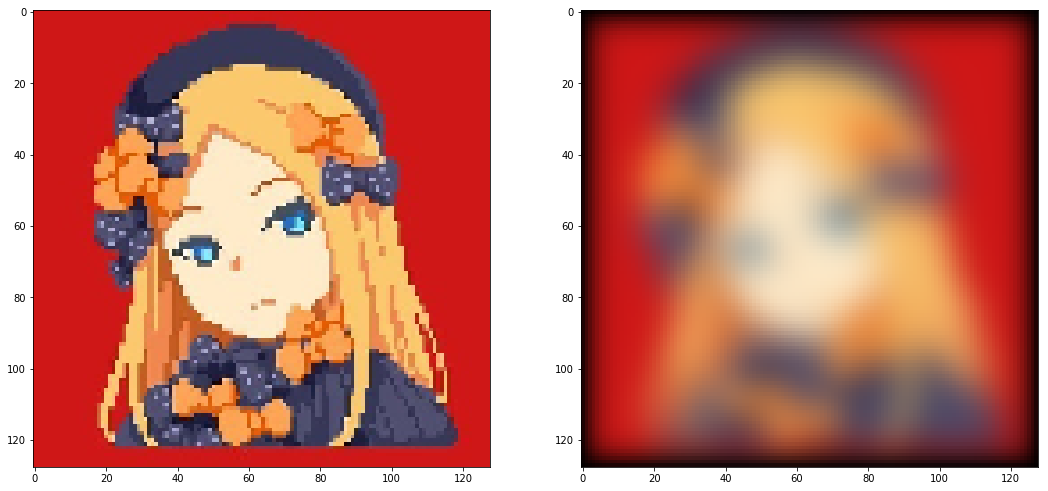

In [107]:
output = gs(testImages)

fake_image = output[2].view(3, 128, 128)
save_image(fake_images.data, 'images/GAN_IO/HISTfake_images.png')
fake = fake_image.numpy()
print(fake.shape)
fake = np.moveaxis(fake, 0, -1)
print(fake.shape)

ori_image = testImages[2].view(3, 128, 128)
save_image(ori_image.data, 'images/GAN_IO/HISTori_image.png')
ori = ori_image.numpy()
print(ori.shape)
ori = np.moveaxis(ori, 0, -1)
print(ori.shape)

imgarr = []
imgarr.append(ori)
imgarr.append(fake)
displayimage(imgarr, c=2)

(0, 256)

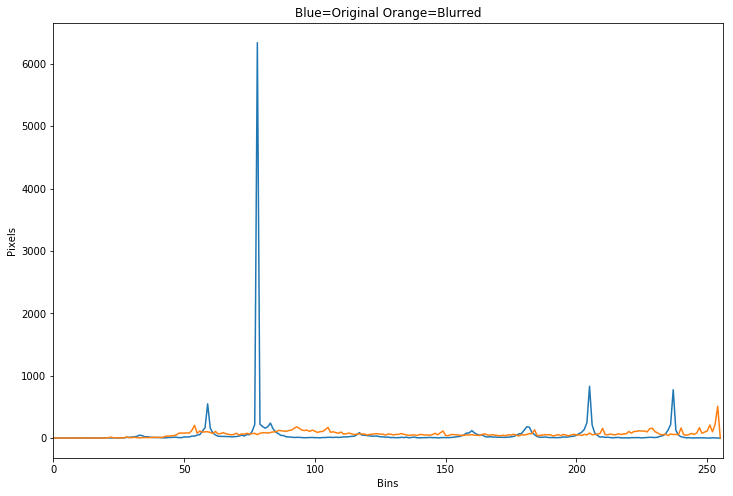

In [108]:
# convert the image to grayscale and create a histogram
image_r = cv2.cvtColor(cv2.imread('images/GAN_IO/HISTori_image.png'), cv2.COLOR_BGR2RGB)
image_p = cv2.cvtColor(cv2.imread('images/GAN_IO/HISTfake_images.png'), cv2.COLOR_BGR2RGB)

grayr = cv2.cvtColor(image_r, cv2.COLOR_RGB2GRAY)
grayp = cv2.cvtColor(image_p, cv2.COLOR_RGB2GRAY)

histr = cv2.calcHist([grayr], [0], None, [256], [0, 256])
histp = cv2.calcHist([grayp], [0], None, [256], [0, 256])
# print(type(histr),type(histp))
# print(histr.shape, histp.shape)
plt.figure(figsize=(12,8))
plt.title("Blue=Original Orange=Blurred")
plt.xlabel("Bins")
plt.ylabel("Pixels")
plt.plot(histr)
plt.plot(histp)
plt.xlim([0, 256])

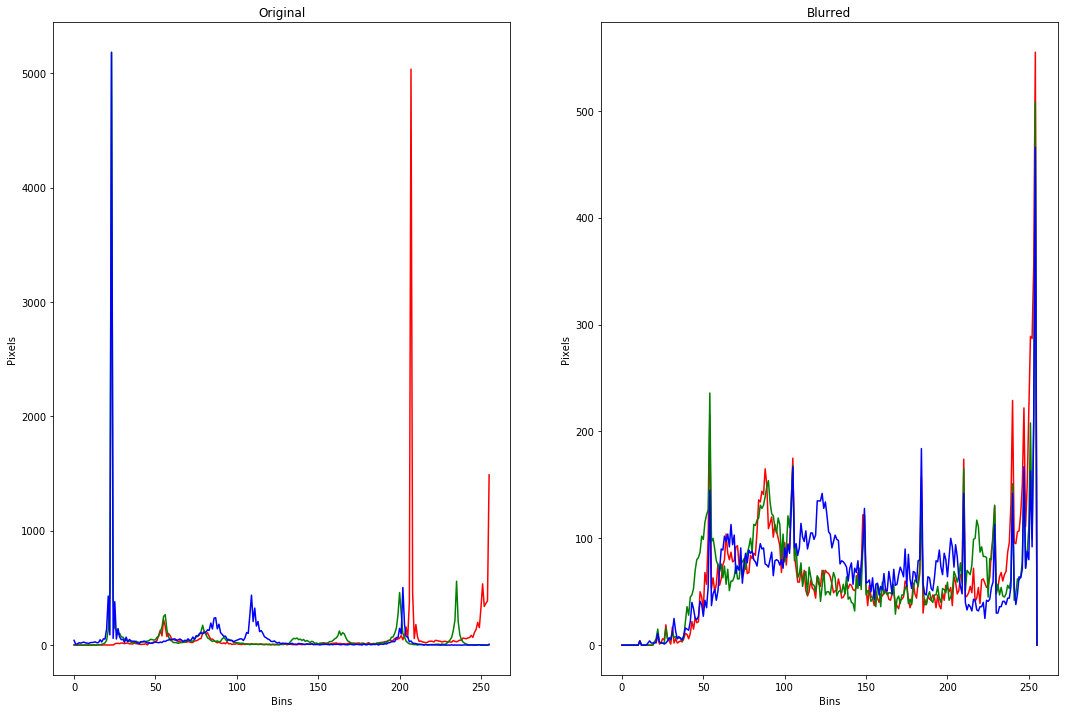

In [110]:
## grab the image channels, initialize the tuple of colors,
# the figure and the flattened feature vector
colors = ('r','g','b')
plt.figure(figsize=(18,12))

chans = cv2.split(image_r)
plt.subplot(1,2,1)
plt.title("Original")
plt.xlabel("Bins")
plt.ylabel("Pixels")
features = []
# loop over the image channels
for (chan, color) in zip(chans, colors):
    # create a histogram for the current channel and
    # concatenate the resulting histograms for each
    # channel
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    features.extend(hist)
    # plot the histogram
    plt.plot(hist, color = color)
    #plt.xlim([0, 256])
    
    
chans = cv2.split(image_p)
plt.subplot(1,2,2)
plt.title("Blurred")
plt.xlabel("Bins")
plt.ylabel("Pixels")
features = []
# loop over the image channels
for (chan, color) in zip(chans, colors):
    # create a histogram for the current channel and
    # concatenate the resulting histograms for each
    # channel
    hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
    features.extend(hist)
    # plot the histogram
    plt.plot(hist, color = color)
